In [1]:
import pandas as pd 
import torch 
import torch.nn as nn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data=pd.read_csv('powerplant_data.csv')
x=data.drop('PE',axis=1)
y=data['PE']
scaler_X = StandardScaler()
scaler_y = StandardScaler()

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

x_train_scaled = scaler_X.fit_transform(x_train)
x_test_scaled = scaler_X.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

tensor_train_data=torch.tensor(x_train_scaled,dtype=torch.float32)
tensor_train_output=torch.tensor(y_train_scaled,dtype=torch.float32)
tensor_test_data=torch.tensor(x_test_scaled,dtype=torch.float32)
tensor_test_output=torch.tensor(y_test_scaled,dtype=torch.float32)

In [3]:
from torch.utils.data import TensorDataset,DataLoader
training_dataset=TensorDataset(tensor_train_data,tensor_train_output)
testing_dataset=TensorDataset(tensor_test_data,tensor_test_output)

In [4]:
trainloader=DataLoader(training_dataset,batch_size=32,shuffle=True)
testloader=DataLoader(testing_dataset,batch_size=32,shuffle=True)

### now lets start with building the ANN

In [5]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            #hidden layer one 
            nn.Linear(x.shape[1],6),
            nn.ReLU(),
            #hidden layer 2 
             nn.Linear(6,6),
            nn.ReLU(),
            #output layer 
            nn.Linear(6,1)
        )
    def forward(self,x):
        return self.model(x)  

### creating our nn model and training it 

In [6]:
import torch.optim as optim 
model=ANN()
criterion=nn.MSELoss()
optimiser=optim.Adam(model.parameters())
training_loss=[]
testing_loss=[]
epochs=25
best_loss=float('inf')
for epoch in range(epochs):
    running_loss=0.0
    model.train()
    for xb,yb in trainloader:
        optimiser.zero_grad()
        output=model(xb)
        loss=criterion(output,yb)
        loss.backward()
        optimiser.step()
        running_loss+=loss.item()
    epoch_training_loss=running_loss/len(trainloader)
    training_loss.append(epoch_training_loss)
    model.eval()
    val_loss=0.0
    with torch.no_grad():
        for xb,yb in testloader:
            output=model(xb)
            loss=criterion(output,yb)
            val_loss+=loss.item()
    epoch_val_loss=val_loss/len(testloader)
    testing_loss.append(epoch_val_loss)
    print(f'for epoch {epoch+1} the epoch training loss is {epoch_training_loss} and validation loss is {epoch_val_loss}')
    if epoch_val_loss<best_loss:
        best_loss=epoch_val_loss
        torch.save(model.state_dict(),'best.pt')
    

for epoch 1 the epoch training loss is 0.4515914071816951 and validation loss is 0.10663172081112862
for epoch 2 the epoch training loss is 0.0822795747468869 and validation loss is 0.06609645476564766
for epoch 3 the epoch training loss is 0.06761363345819214 and validation loss is 0.06304431650787592
for epoch 4 the epoch training loss is 0.06551789036796739 and validation loss is 0.0612337727099657
for epoch 5 the epoch training loss is 0.06446100188574443 and validation loss is 0.059948412453134856
for epoch 6 the epoch training loss is 0.06373883799339335 and validation loss is 0.059146426742275555
for epoch 7 the epoch training loss is 0.06331724796133736 and validation loss is 0.05900106610109409
for epoch 8 the epoch training loss is 0.06319829615143438 and validation loss is 0.05840271568546693
for epoch 9 the epoch training loss is 0.06265716673030207 and validation loss is 0.0583219309647878
for epoch 10 the epoch training loss is 0.06244835656446715 and validation loss is 0

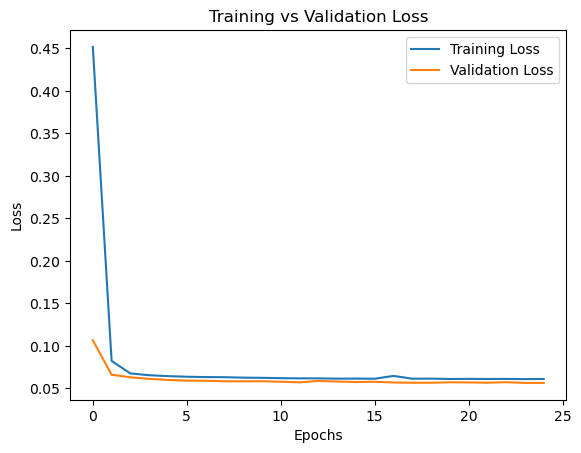

In [7]:
import matplotlib.pyplot as plt 
plt.plot(range(epochs), training_loss, label="Training Loss")
plt.plot(range(epochs), testing_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()


In [8]:
model.load_state_dict(torch.load("best.pt"))
model.eval()
from sklearn.metrics import r2_score
criterion = nn.MSELoss()

with torch.no_grad():
    outputs = model(tensor_test_data)
    mse = criterion(outputs, tensor_test_output)

print("Test MSE:", mse.item())
print("Test data r2 score is :",r2_score(tensor_test_output,outputs) )

Test MSE: 0.056434307247400284
Test data r2 score is : 0.9423078330114929
